## Notebook to run post processing of differential expression in single-cell data for glm pseudo-bulk based analysis

basically 
- read glm results per region and cell-type and then integrate them
- apply B&H FDR 
- take a look at overlap between brain regions and cell-types do some sample plotting

In [1]:
!date

Mon Nov  8 13:15:14 EST 2021


#### import libraries and set notebook variables

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import json

import warnings
warnings.simplefilter('ignore')

import random
random.seed(420)

In [3]:
# parameters
cohort = 'aging'
assay = 'RNA'

# directories for initial setup
home_dir = '/labshare/raph/datasets/adrd_neuro'
wrk_dir = f'{home_dir}/{cohort}'
quants_dir = f'{wrk_dir}/demux'
results_dir = f'{wrk_dir}/results'

# in files
data_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.Age_group_young_old.h5ad'
tissue_out_file = '{this_dir}/{chrt}.{name}.glm_pb_age_diffs.csv'

# out files
results_file = f'{results_dir}/{cohort}.glm_pb_age_diffs.csv'
results_fdr_file = f'{results_dir}/{cohort}.glm_pb_age_diffs_fdr.csv'

# constants
region_obs_feature = 'Brain_region'
celltype_obs_feature = 'new_anno'
min_cell_count = 3
young_age_limit = 30.0
sns.set_theme(style='white', palette='Paired', font_scale=1.2) 

#### analysis functions

In [31]:
def read_glm_results(group_name: str, group_type: str) -> pd.DataFrame:
    this_file = tissue_out_file.format(this_dir=results_dir, chrt=cohort, 
                                       name=group_name.replace(" ", "_"))
    this_df = pd.read_csv(this_file)
    this_df['tissue'] = group_name
    this_df['type'] = 'brain_region' if group_type == region_obs_feature else 'cell_type'     
    return this_df

def compute_bh_fdr(df: pd.DataFrame, alpha: float=0.05, p_col: str='p-value',
                   method: str='fdr_bh', verbose: bool=True) -> pd.DataFrame:
    ret_df = df.copy()
    test_adjust = smm.multipletests(np.array(ret_df[p_col]), alpha=alpha, 
                                    method=method)
    ret_df[method] = test_adjust[1]
    if verbose:
        print(f'total significant after correction: {ret_df.loc[ret_df[method] < alpha].shape}')
    return ret_df

def compute_frmt_pb(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    ret_df = df[[feature, 'Sample_id']].groupby('Sample_id').mean()
    ret_df = ret_df.merge(df[['Sample_id', 'pool_name', 'old']].drop_duplicates(), 
                          how='left', left_index=True, right_on='Sample_id')
    return ret_df

def plot_feature_by_age_group(df: pd.DataFrame, x_term: str, y_term: str):
    plt.figure(figsize=(9,9))
    pb_df = compute_frmt_pb(df, y_term)
    sns.boxenplot(x=x_term,y=y_term, scale='exponential', data=pb_df,
                  k_depth='trustworthy')

    grsplt = sns.stripplot(x=x_term,y=y_term, data=pb_df, alpha=0.75,
                           jitter=True, color='darkgrey')
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel(x_term)
    plt.ylabel(y_term)
    plt.show()
    
def plot_feature_by_sample(df: pd.DataFrame, x_term: str, y_term: str):
    # set up order by young then old
    temp = df.groupby('Age_group')['Sample_id'].unique()
    this_list = temp['young'].to_list() + temp['old'].to_list() 
    plt.figure(figsize=(9,9))
    sns.boxenplot(x='Sample_id',y=y_term, scale='exponential', data=df,
                  k_depth='trustworthy', hue=x_term, order=this_list)
    grsplt = sns.stripplot(x='Sample_id',y=y_term, data=df, alpha=0.75,
                           jitter=True, color='darkgrey', order=this_list)
    plt.xticks(rotation=75)
    plt.title(f'{y_term} ~ {x_term}', fontsize='large') 
    plt.xlabel('Sample')
    plt.ylabel(y_term)
    plt.show()    
    
def volcano_plot(df: pd.DataFrame, x_term: str='coef', y_term: str='p-value', 
                 alpha: float=0.05, adj_p_col: str='fdr_bh', title: str=None, 
                 filter_nseeff: bool=True, extreme_size: float=10.0):
    if filter_nseeff:
        df = df.loc[((-extreme_size < df[x_term]) & 
                    (df[x_term] < extreme_size) &
                    (~df['z'].isna()) | 
                    (df[adj_p_col] < alpha))]
    plt.figure(figsize=(9,9))
    log_pvalue = -np.log10(df[y_term])
    is_sig = df[adj_p_col] < alpha
    sns.scatterplot(x=x_term, y=log_pvalue, data=df, hue=is_sig)
    plt.title(title)
    plt.xlabel('effect')
    plt.ylabel('-log10(p-value)')
    plt.show()
    
def prep_plot_feature(data: ad.AnnData, feature_results: pd.Series, 
                      group: str='old', filter_zeros: bool=False):
    this_type = region_obs_feature if feature_results.type == 'brain_region' else celltype_obs_feature   
    this_ad = subset_ad_by_type(data, feature_results.tissue, this_type)
    this_df = convert_ad_to_df(this_ad)
    if filter_zeros:
        this_df = this_df.loc[this_df[feature_results.feature] > 0]
    print(feature_results)
    sns.set_theme(style='white', palette='Paired', font_scale=1.2)
    plot_feature_by_age_group(this_df, group, feature_results.feature)
    plot_feature_by_sample(this_df, group, feature_results.feature)
    
def subset_ad_by_type(data: ad.AnnData, group_name: str, type_name: str,
                      reapply_filter: bool=True, min_cell_count: int=3,
                      verbose: bool=False) -> ad.AnnData:
    this_data = data[data.obs[type_name] == group_name].copy()
    shape_before = this_data.shape
    if reapply_filter:
        sc.pp.filter_genes(this_data, min_counts=min_cell_count)
        sc.pp.filter_cells(this_data, min_counts=min_cell_count)
        shape_after = this_data.shape
    if verbose:
        print(f'shape before and after: {shape_before} {shape_after}')
        print(this_data)
    return this_data

def convert_ad_to_df(data: ad.AnnData, young_age_limit: float=30.0, 
                     verbose: bool=False) -> pd.DataFrame:
    data_df = data.to_df()
    annots = data.obs[['Brain_region', 'Age','Age_group', 'pool_name', 
                       'Sample_id', 'Sex', 'donor_id']].copy()
    annots['old'] = np.where((annots['Age'] > young_age_limit), 1, 0)
    annots['female'] = np.where((annots['Sex'] == 'Female'), 1, 0)
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = pd.concat([data_df, annots], axis='columns')
        if verbose:
            print(this_df.shape)
            display(this_df.head())
    return this_df

#### read the anndata (h5ad) file

In [5]:
%%time
adata = sc.read(data_file, cache=True)
print(adata)

Only considering the two last: ['.Age_group_young_old', '.h5ad'].
Only considering the two last: ['.Age_group_young_old', '.h5ad'].
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X

#### take a look at the cell counts by cell type

In [6]:
# get cell counts by 'categories'
categories = ['Brain_region', 'new_anno']
for this_cat in categories:
    print(adata.obs[this_cat].value_counts())

Entorhinal cortex        54399
Putamen                  49625
Subventricular zone      36610
Middle temporal gyrus    27311
Name: Brain_region, dtype: int64
Oligodendrocyte-1    36479
SPN D1               15379
SPN D2               15280
Oligodendrocyte-2    12844
Astrocyte            12208
ExN CUX2 LAMP5        9055
uncertain             7548
InN ADARB2 VIP        7014
ExN FEZF2             6842
OPC                   6682
ExN RORB THEMIS       5130
InN LHX6 PVALB        4566
Radial Glia           3669
Microglia             3265
InN ADARB2 LAMP5      3216
ExN CUX2 ADARB2       3066
InN LHX6 SST          2937
uncertain-2           2677
SPN D1-2              2388
Endothelial           2246
ExN RORB              1966
ExN LAMP5             1963
Astrocyte-GFAP-Hi      599
SPN D2-2               465
ExN THEMIS             461
Name: new_anno, dtype: int64


#### get sample counts per age group by  counts by 'categories'

In [7]:
for this_cat in categories:
    print(adata.obs.groupby([this_cat,'Age_group'])['Sample_id'].nunique())

Brain_region           Age_group
Entorhinal cortex      old          6
                       young        6
Middle temporal gyrus  old          7
                       young        5
Putamen                old          7
                       young        5
Subventricular zone    old          6
                       young        6
Name: Sample_id, dtype: int64
new_anno           Age_group
Astrocyte          old          26
                   young        22
Astrocyte-GFAP-Hi  old           0
                   young         1
Endothelial        old          26
                   young        22
ExN CUX2 ADARB2    old           8
                   young         8
ExN CUX2 LAMP5     old          24
                   young        20
ExN FEZF2          old          15
                   young        13
ExN LAMP5          old           7
                   young         6
ExN RORB           old           8
                   young         8
ExN RORB THEMIS    old          14
         

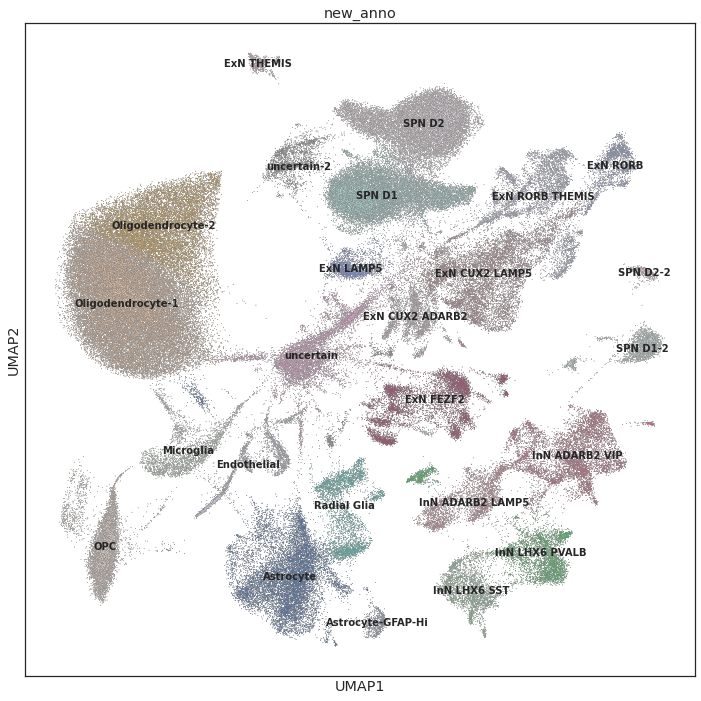

In [8]:
with rc_context({'figure.figsize': (12, 12)}):
    sc.pl.umap(adata, color=[celltype_obs_feature], legend_loc='on data', 
               add_outline=True, legend_fontsize=10)

##### find cell-types not used in analysis
remove them, and then refilter genes based on cell count

In [9]:
found_uncertain = [x for x in adata.obs[celltype_obs_feature].unique().to_list() 
                   if 'uncertain' in x] + ['Astrocyte-GFAP-Hi']
print(found_uncertain)
adata = adata[~adata.obs[celltype_obs_feature].isin(found_uncertain ), :]
sc.pp.filter_genes(adata, min_cells=min_cell_count)
adata

['uncertain', 'uncertain-2', 'Astrocyte-GFAP-Hi']


Trying to set attribute `.var` of view, copying.


AnnData object with n_obs × n_vars = 157121 × 34609
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std', 'new_anno_colors'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap_085'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_sum'

### read the diff by age results by region and cell-type

In [13]:
%%time
glm_results = None
for this_type in categories:
    for this_tissue in adata.obs[this_type].unique():
        glm_results = pd.concat([glm_results, read_glm_results(this_tissue, 
                                                                  this_type)])

CPU times: user 466 ms, sys: 32.8 ms, total: 498 ms
Wall time: 1.84 s


In [14]:
print(glm_results.shape)
display(glm_results.head())

(226712, 9)


feature  intercept      coef    stderr         z   p-value   log2_fc  \
0  AL136537.1   0.023133 -0.005919  0.009623 -0.615085  0.538499 -0.426395   
1        PTMS   0.480921 -0.070454  0.092577 -0.761027  0.446641 -0.228532   
2  AC138819.1   0.050241 -0.015024  0.013509 -1.112148  0.266075 -0.512569   
3         SRF   0.160269  0.022370  0.027403  0.816313  0.414321  0.188498   
4       SYT11   2.032322 -0.067210  0.145104 -0.463182  0.643234 -0.048517   

                  tissue          type  
0  Middle temporal gyrus  brain_region  
1  Middle temporal gyrus  brain_region  
2  Middle temporal gyrus  brain_region  
3  Middle temporal gyrus  brain_region  
4  Middle temporal gyrus  brain_region

In [15]:
glm_results['tissue'].value_counts()

Subventricular zone      18066
Putamen                  17236
Entorhinal cortex        16025
Middle temporal gyrus    14897
InN ADARB2 VIP           12338
ExN CUX2 LAMP5           11613
ExN RORB THEMIS          10836
ExN CUX2 ADARB2          10789
SPN D1                   10249
InN LHX6 PVALB           10040
SPN D2                    9828
Radial Glia               9300
ExN FEZF2                 9291
Oligodendrocyte-1         7925
InN LHX6 SST              7768
ExN RORB                  7340
Astrocyte                 6841
InN ADARB2 LAMP5          6438
Oligodendrocyte-2         6323
SPN D1-2                  5564
OPC                       4275
Microglia                 4236
ExN THEMIS                3643
Endothelial               2647
SPN D2-2                  2056
ExN LAMP5                 1148
Name: tissue, dtype: int64

#### compute the FDR values

In [16]:
glm_results['p-value'] = glm_results['p-value'].fillna(1)
glm_results = compute_bh_fdr(glm_results)
print(glm_results.shape)
display(glm_results.head())

total significant after correction: (894, 10)
(226712, 10)


feature  intercept      coef    stderr         z   p-value   log2_fc  \
0  AL136537.1   0.023133 -0.005919  0.009623 -0.615085  0.538499 -0.426395   
1        PTMS   0.480921 -0.070454  0.092577 -0.761027  0.446641 -0.228532   
2  AC138819.1   0.050241 -0.015024  0.013509 -1.112148  0.266075 -0.512569   
3         SRF   0.160269  0.022370  0.027403  0.816313  0.414321  0.188498   
4       SYT11   2.032322 -0.067210  0.145104 -0.463182  0.643234 -0.048517   

                  tissue          type    fdr_bh  
0  Middle temporal gyrus  brain_region  0.816256  
1  Middle temporal gyrus  brain_region  0.768539  
2  Middle temporal gyrus  brain_region  0.658390  
3  Middle temporal gyrus  brain_region  0.750576  
4  Middle temporal gyrus  brain_region  0.865026

#### count of significant genes by brain region

In [17]:
print(glm_results.loc[glm_results['fdr_bh'] < 0.05]['tissue'].nunique())
glm_results.loc[glm_results['fdr_bh'] < 0.05]['tissue'].value_counts()

26


ExN RORB                 122
Middle temporal gyrus     80
InN ADARB2 VIP            75
OPC                       65
InN LHX6 PVALB            64
Microglia                 57
Entorhinal cortex         51
Putamen                   51
Subventricular zone       47
Astrocyte                 38
Oligodendrocyte-2         36
ExN CUX2 ADARB2           35
Oligodendrocyte-1         35
ExN RORB THEMIS           23
SPN D2-2                  20
ExN LAMP5                 16
Endothelial               15
InN ADARB2 LAMP5          12
InN LHX6 SST              10
ExN FEZF2                 10
ExN THEMIS                 9
ExN CUX2 LAMP5             8
SPN D1-2                   6
SPN D2                     6
SPN D1                     2
Radial Glia                1
Name: tissue, dtype: int64

#### save the full results

In [18]:
glm_results.to_csv(results_file, index=False)

#### save the statistically significant results

In [19]:
glm_results.loc[glm_results['fdr_bh'] < 0.05].to_csv(results_fdr_file, index=False)

In [20]:
display(glm_results.loc[glm_results['fdr_bh'] < 0.05].head())

feature  intercept      coef    stderr         z   p-value   log2_fc  \
139        ROBO1   3.430727 -0.445822  0.108117 -4.123513  0.000037 -0.200829   
819        SNX19   0.919216  0.265578  0.064311  4.129603  0.000036  0.366160   
882      GAGE12J   0.000017  0.000565  0.000138  4.104943  0.000040  5.081586   
1214        HHAT   0.376011  0.295074  0.075454  3.910648  0.000092  0.835722   
1312  AL161804.1   0.093955 -0.042788  0.009728 -4.398599  0.000011 -0.876754   

                     tissue          type    fdr_bh  
139   Middle temporal gyrus  brain_region  0.021020  
819   Middle temporal gyrus  brain_region  0.020700  
882   Middle temporal gyrus  brain_region  0.022161  
1214  Middle temporal gyrus  brain_region  0.033580  
1312  Middle temporal gyrus  brain_region  0.009880

#### visualize volcano plots

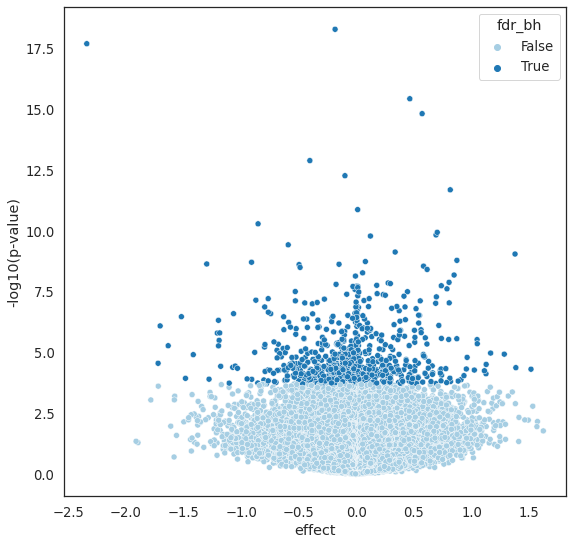

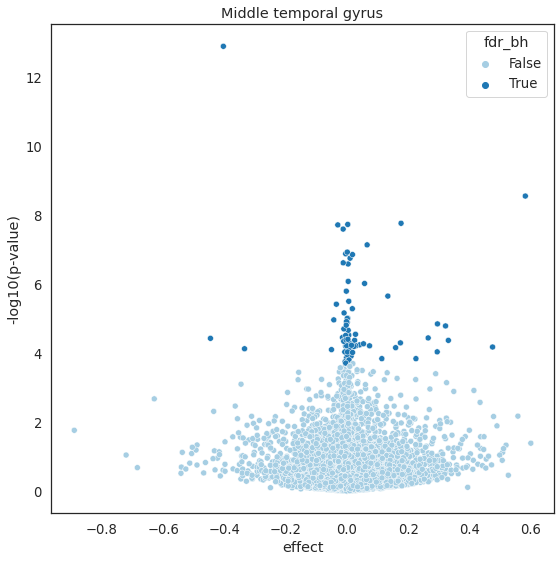

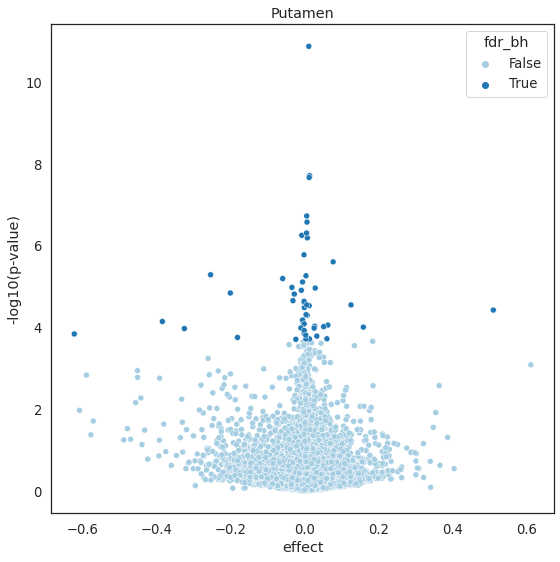

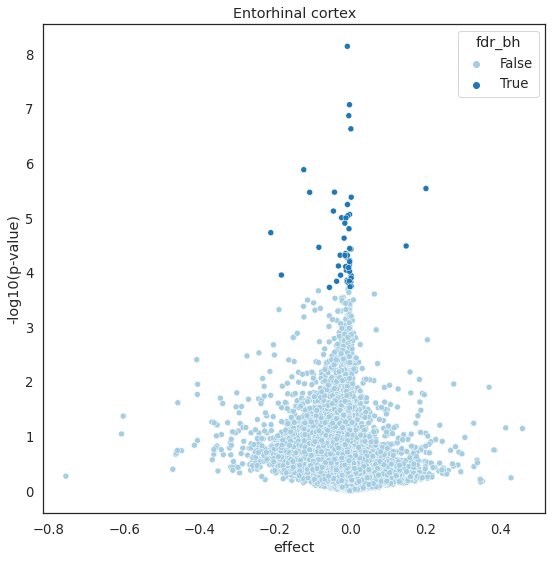

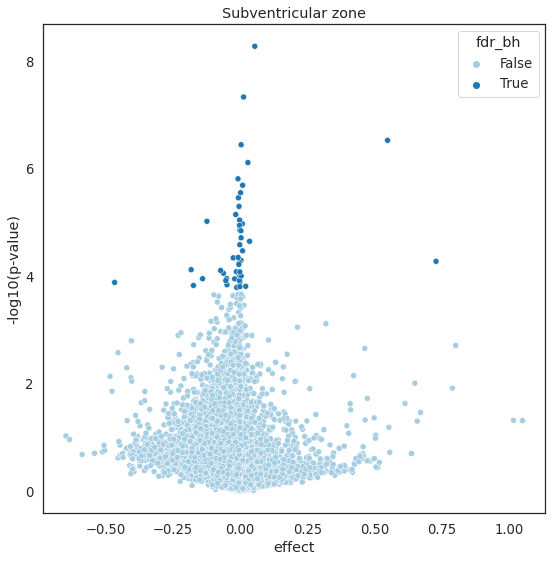

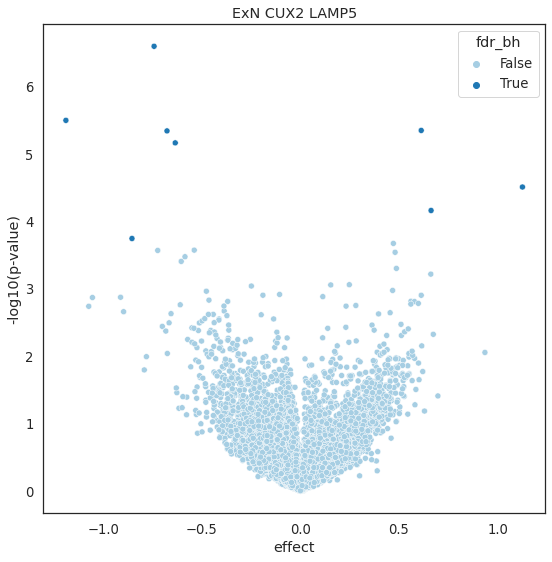

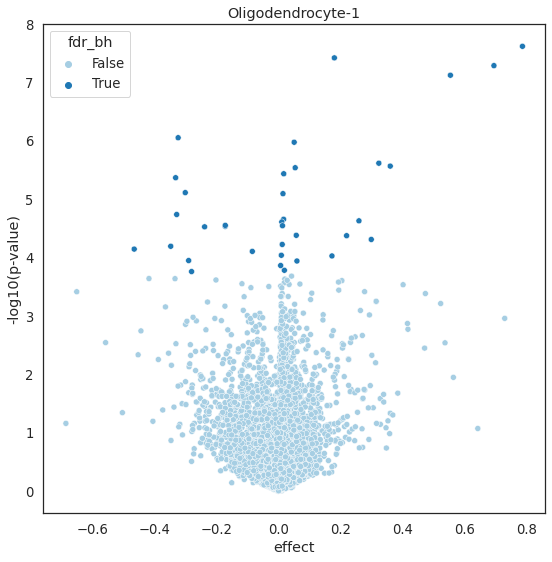

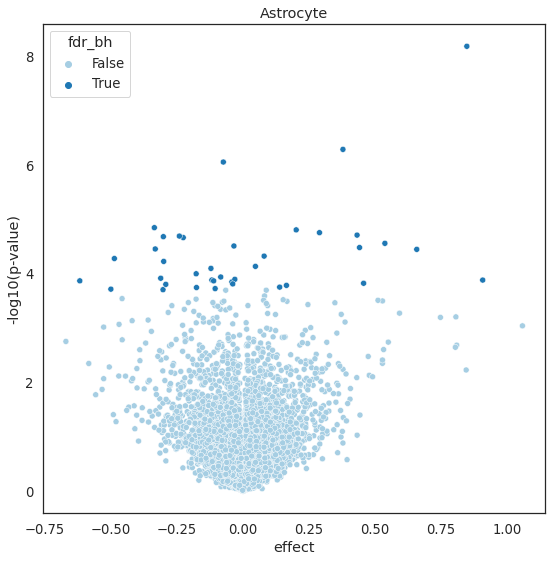

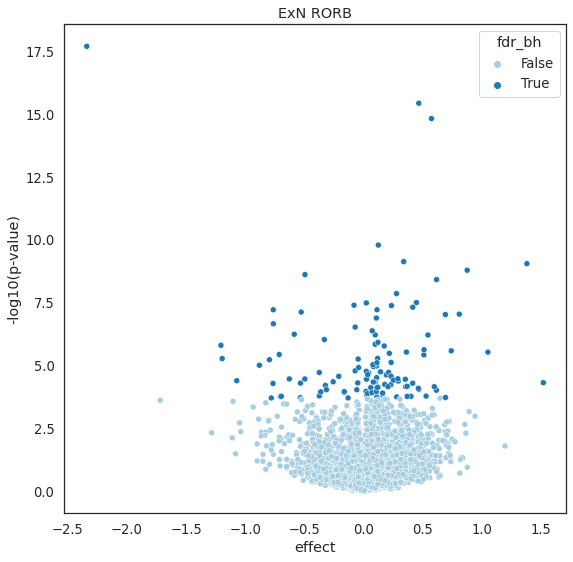

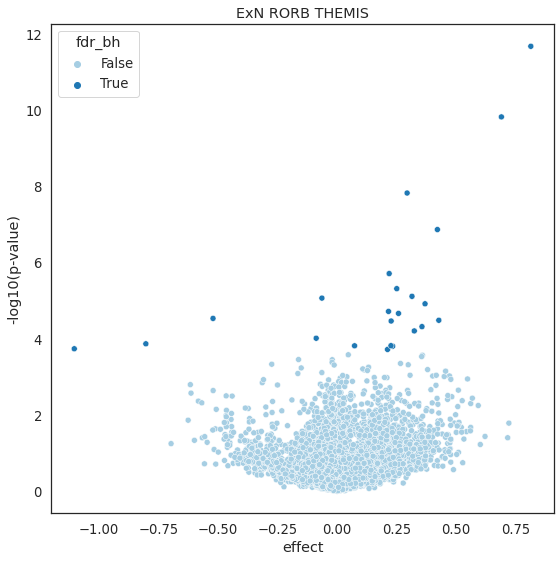

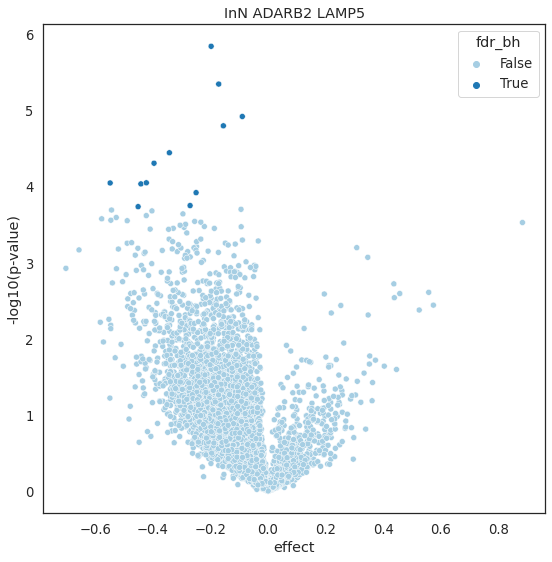

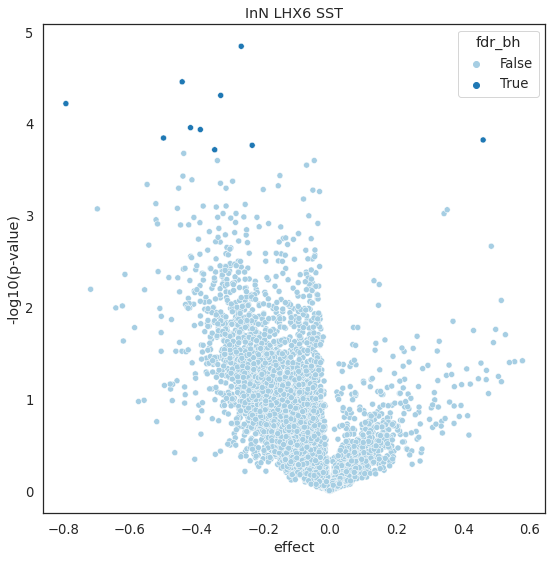

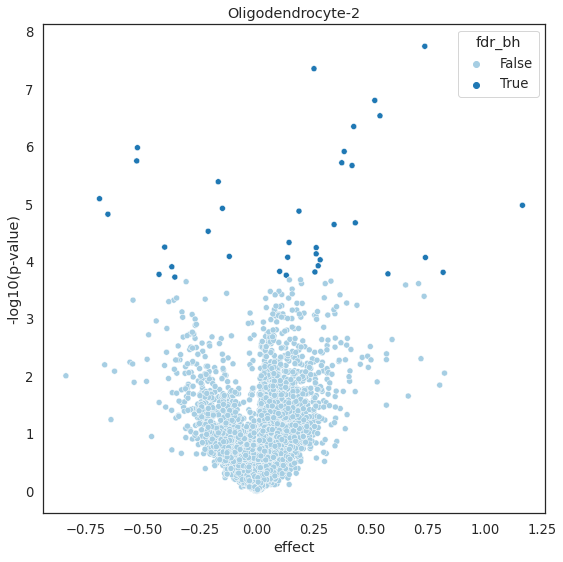

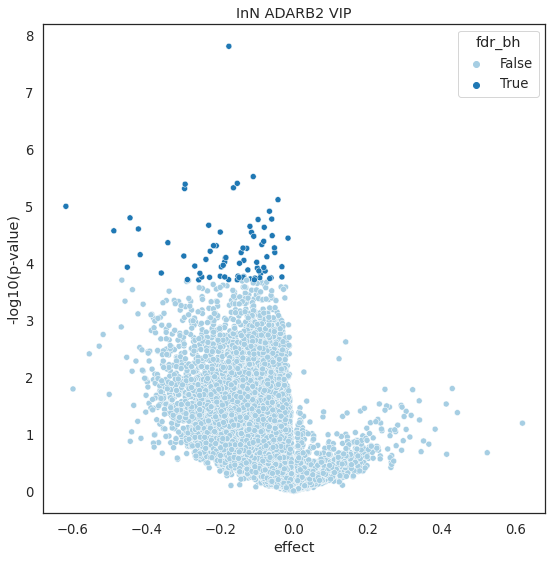

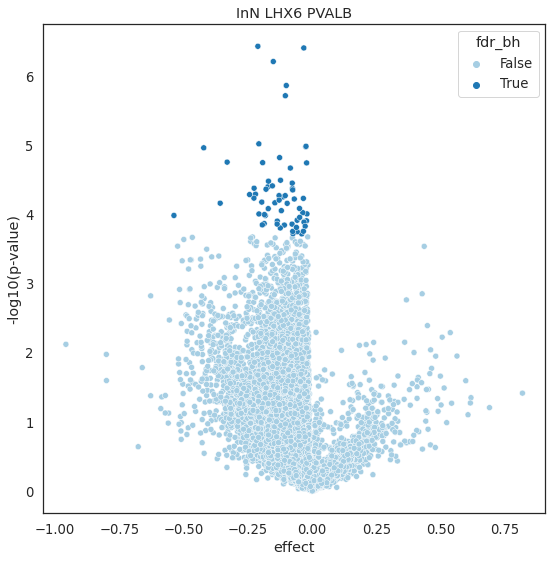

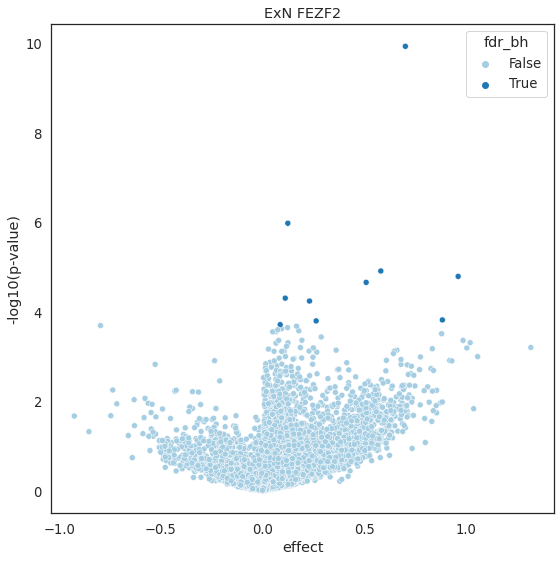

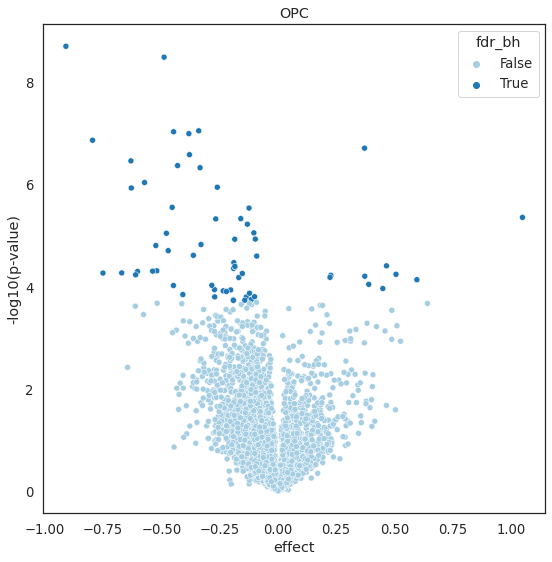

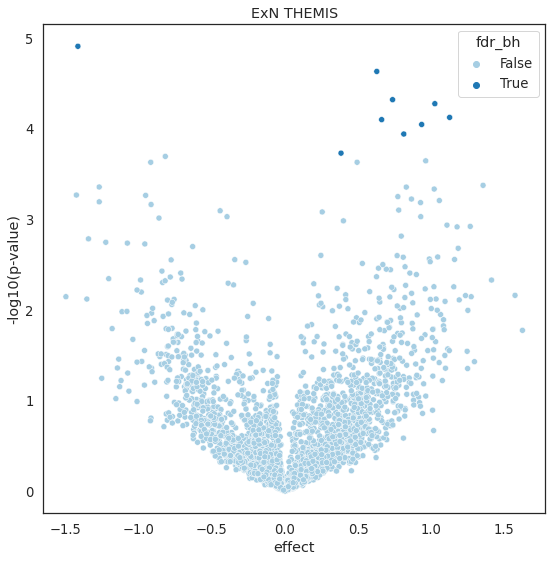

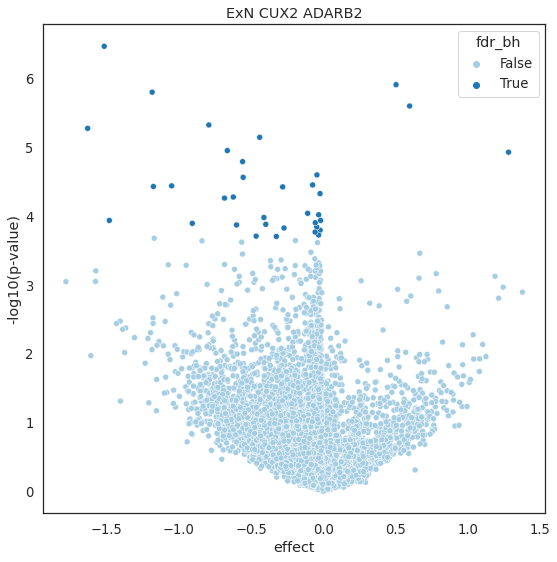

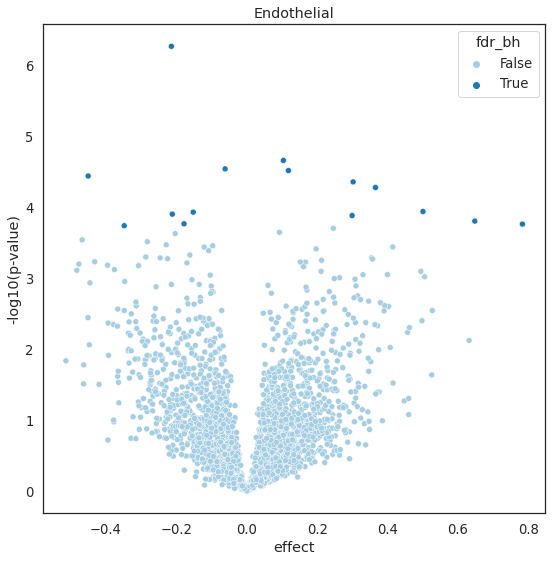

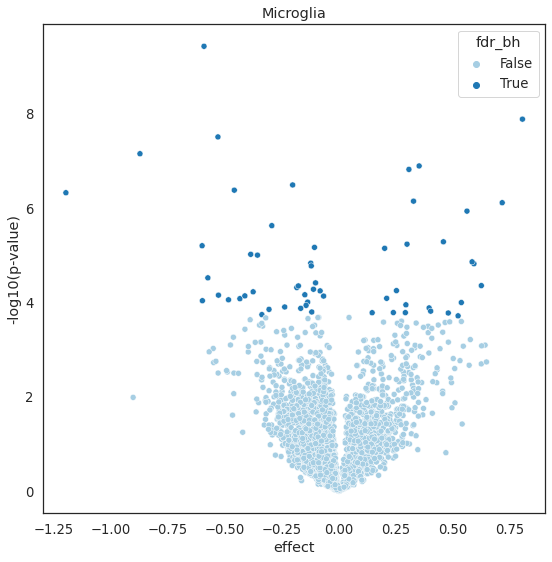

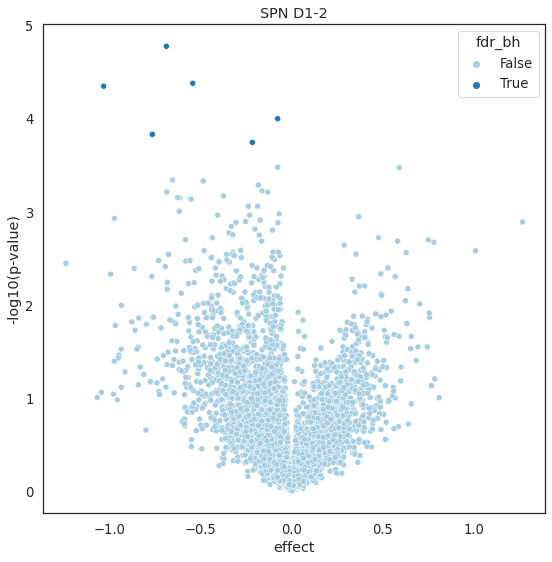

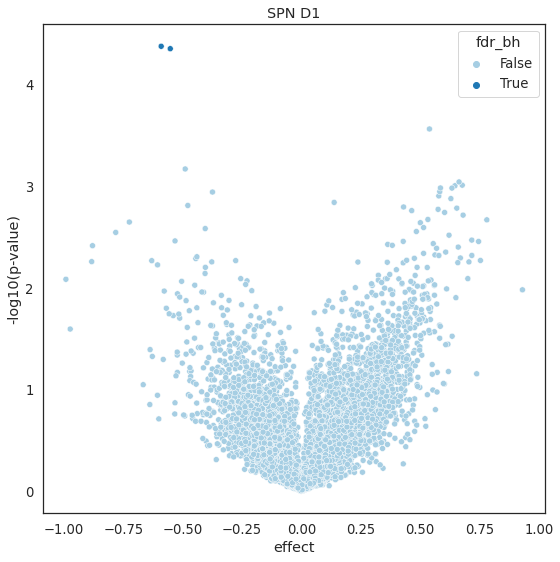

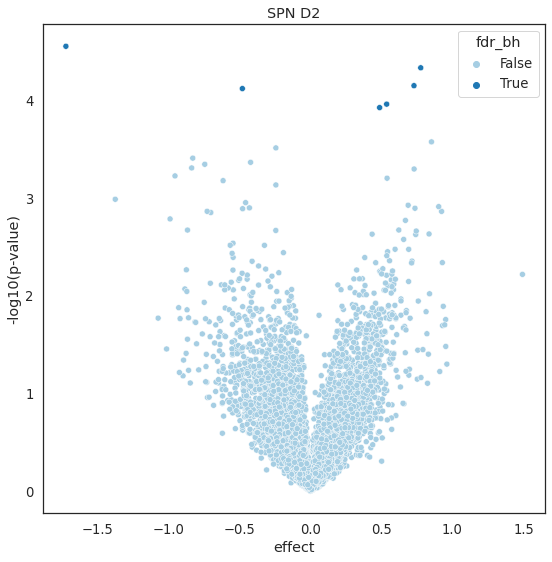

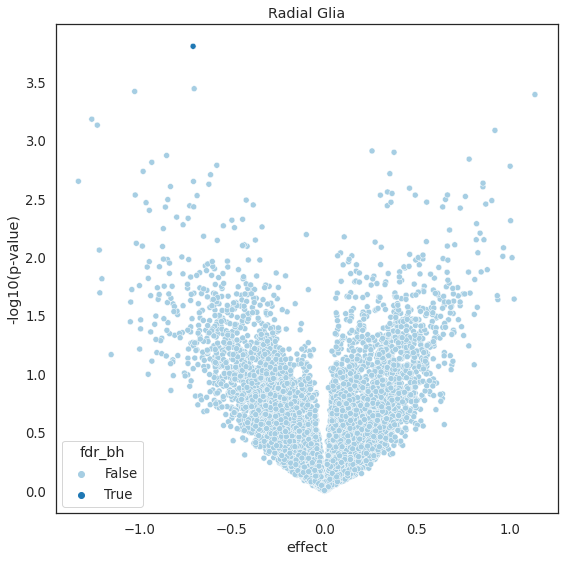

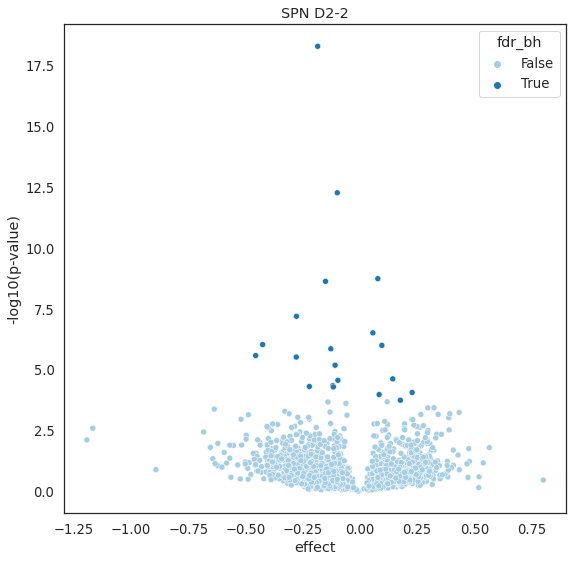

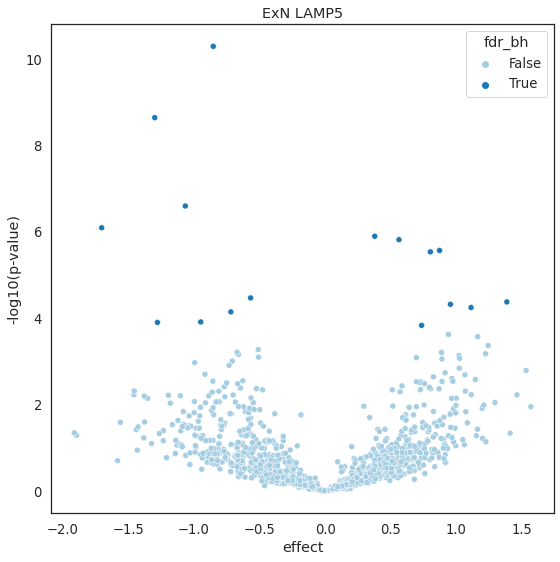

In [21]:
volcano_plot(glm_results)

for tissue in glm_results['tissue'].unique():
    volcano_plot(glm_results.loc[glm_results['tissue'] == tissue], title=tissue)

In [22]:
glm_results.head()

feature  intercept      coef    stderr         z   p-value   log2_fc  \
0  AL136537.1   0.023133 -0.005919  0.009623 -0.615085  0.538499 -0.426395   
1        PTMS   0.480921 -0.070454  0.092577 -0.761027  0.446641 -0.228532   
2  AC138819.1   0.050241 -0.015024  0.013509 -1.112148  0.266075 -0.512569   
3         SRF   0.160269  0.022370  0.027403  0.816313  0.414321  0.188498   
4       SYT11   2.032322 -0.067210  0.145104 -0.463182  0.643234 -0.048517   

                  tissue          type    fdr_bh  
0  Middle temporal gyrus  brain_region  0.816256  
1  Middle temporal gyrus  brain_region  0.768539  
2  Middle temporal gyrus  brain_region  0.658390  
3  Middle temporal gyrus  brain_region  0.750576  
4  Middle temporal gyrus  brain_region  0.865026

#### look at some of the individual results

feature      AC128709.3
intercept      0.264994
coef          -0.184657
stderr         0.020723
z             -8.910612
p-value             0.0
log2_fc       -1.721822
tissue         SPN D2-2
type          cell_type
fdr_bh              0.0
Name: 1211, dtype: object


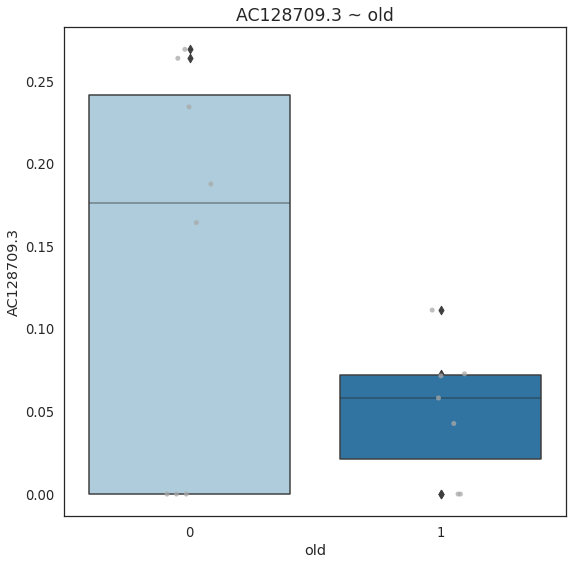

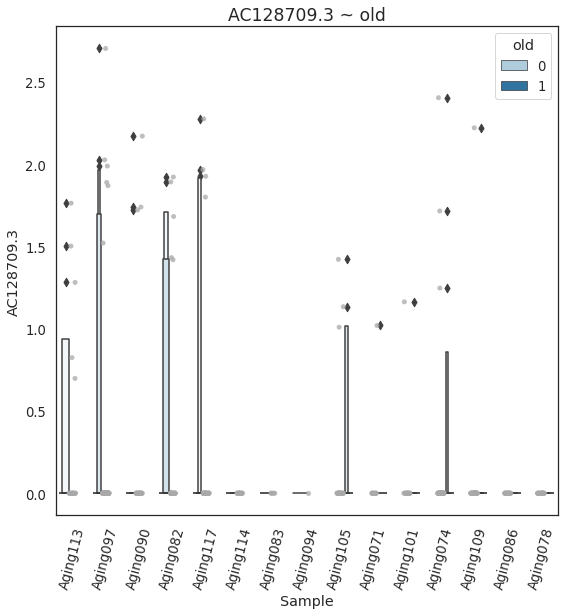

feature      AC128709.3
intercept      0.264994
coef          -0.184657
stderr         0.020723
z             -8.910612
p-value             0.0
log2_fc       -1.721822
tissue         SPN D2-2
type          cell_type
fdr_bh              0.0
Name: 1211, dtype: object


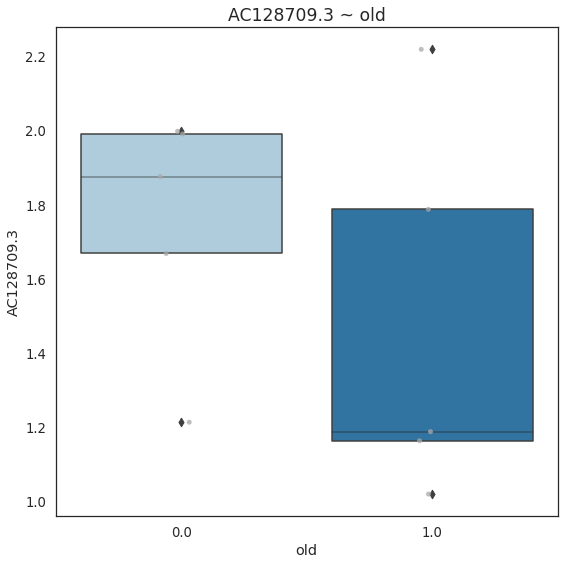

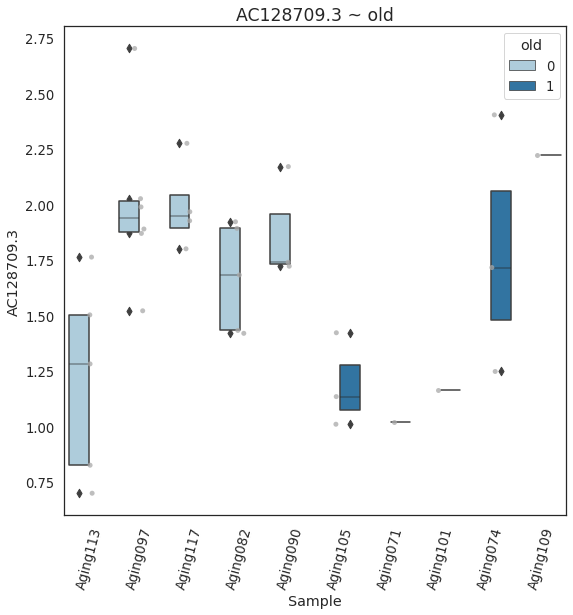

In [35]:
# max significant by p-value
this_results = glm_results.loc[glm_results['p-value'] == min(glm_results['p-value'])]
this_hit = this_results.sort_values(by=['coef'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature           SGCZ
intercept     3.465944
coef         -2.339767
stderr        0.267159
z            -8.757971
p-value            0.0
log2_fc      -1.621814
tissue        ExN RORB
type         cell_type
fdr_bh             0.0
Name: 2670, dtype: object


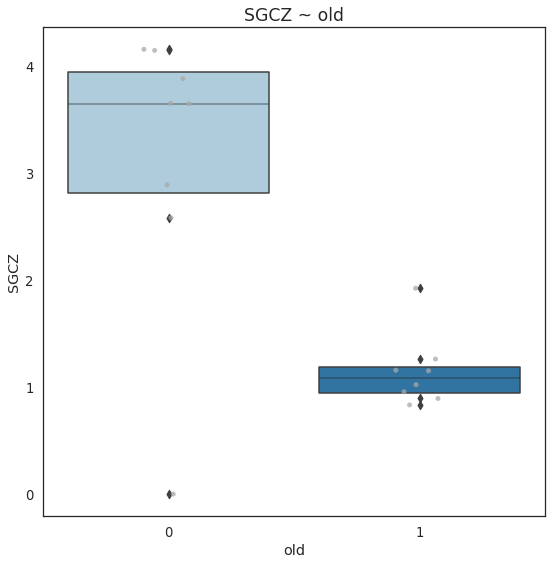

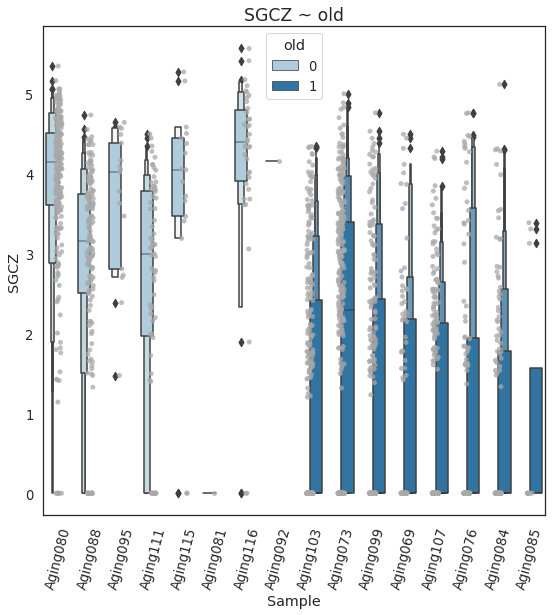

feature           SGCZ
intercept     3.465944
coef         -2.339767
stderr        0.267159
z            -8.757971
p-value            0.0
log2_fc      -1.621814
tissue        ExN RORB
type         cell_type
fdr_bh             0.0
Name: 2670, dtype: object


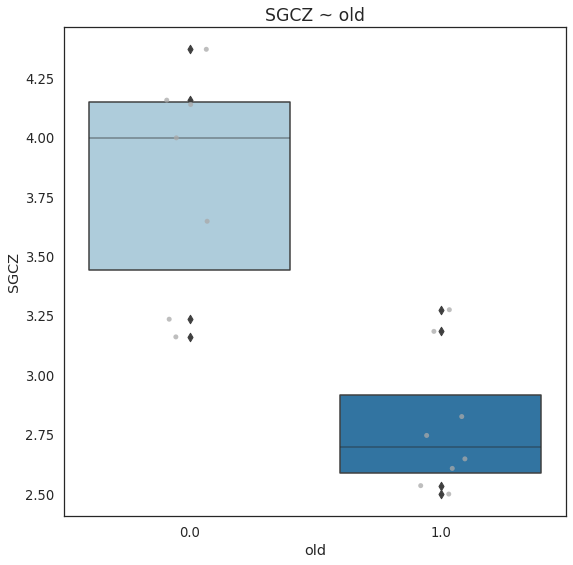

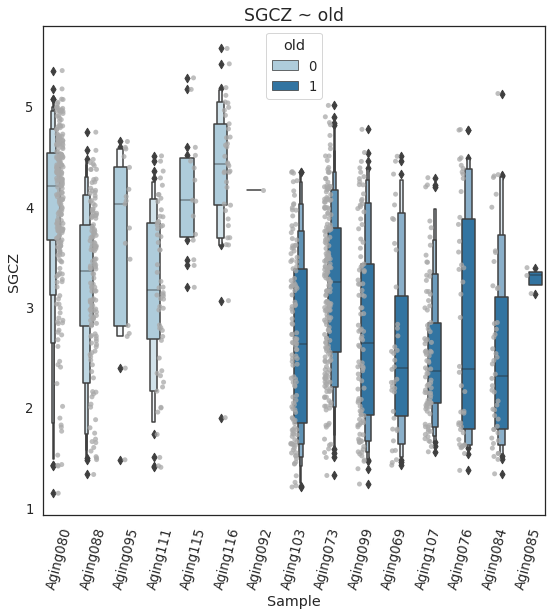

In [36]:
# min significant by coef (increasing)
sig_results = glm_results.loc[glm_results['fdr_bh'] < 0.05]
this_results = sig_results.loc[sig_results['coef'] == min(sig_results['coef'])]
this_hit = this_results.sort_values(by=['coef'], ascending=False).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature                      LAMA4
intercept                 0.390848
coef                      0.176959
stderr                    0.031389
z                         5.637613
p-value                        0.0
log2_fc                   0.538793
tissue       Middle temporal gyrus
type                  brain_region
fdr_bh                    0.000122
Name: 1926, dtype: object


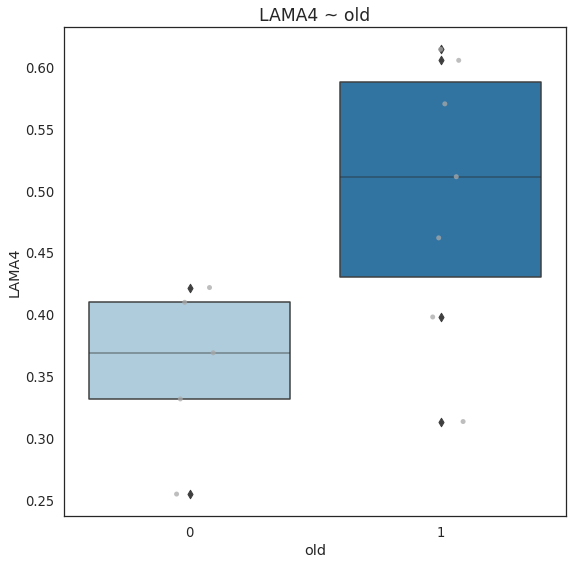

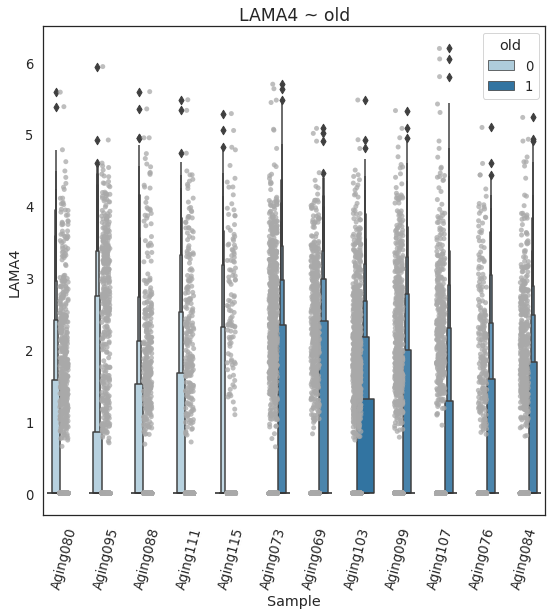

feature                      LAMA4
intercept                 0.390848
coef                      0.176959
stderr                    0.031389
z                         5.637613
p-value                        0.0
log2_fc                   0.538793
tissue       Middle temporal gyrus
type                  brain_region
fdr_bh                    0.000122
Name: 1926, dtype: object


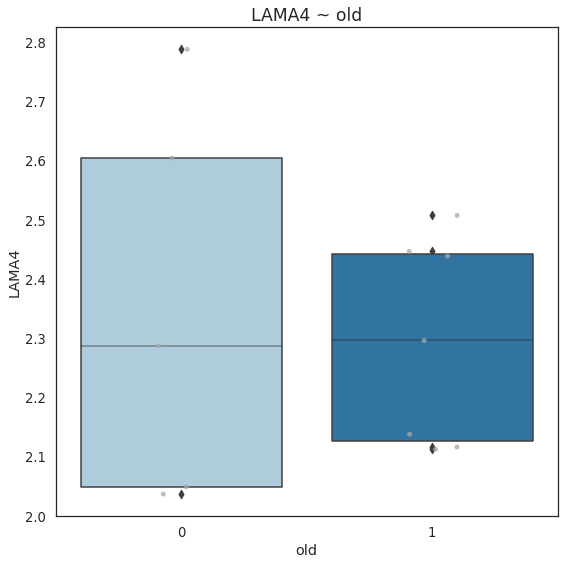

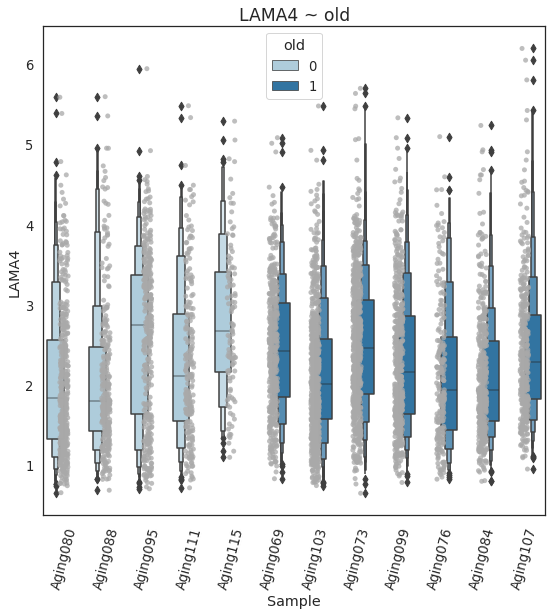

In [37]:
# random
this_hit = sig_results.sample().iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)

feature           LRP1B
intercept      4.159529
coef           1.622737
stderr         0.678567
z              2.391417
p-value        0.016783
log2_fc        0.475215
tissue       ExN THEMIS
type          cell_type
fdr_bh         0.297955
Name: 1113, dtype: object


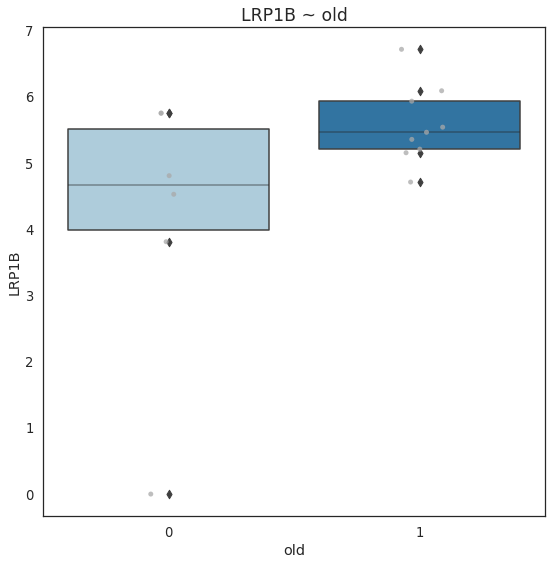

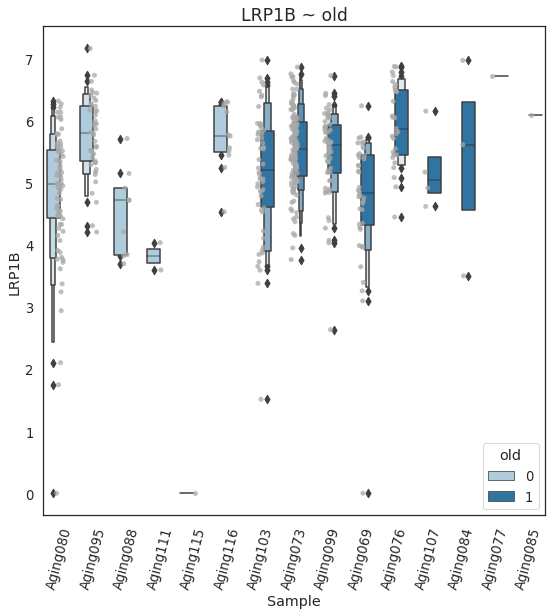

feature           LRP1B
intercept      4.159529
coef           1.622737
stderr         0.678567
z              2.391417
p-value        0.016783
log2_fc        0.475215
tissue       ExN THEMIS
type          cell_type
fdr_bh         0.297955
Name: 1113, dtype: object


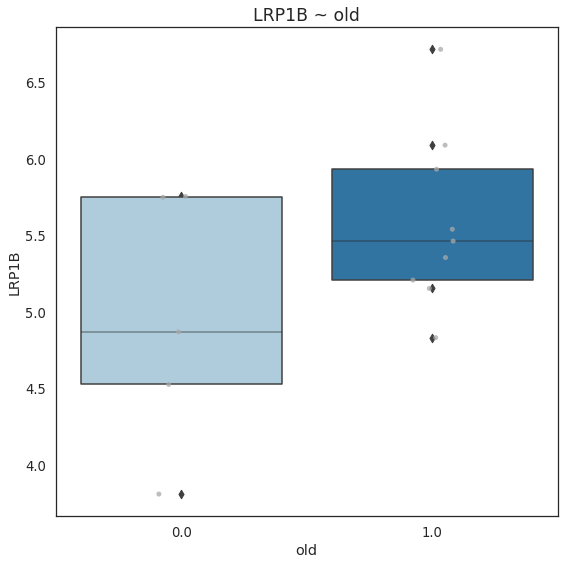

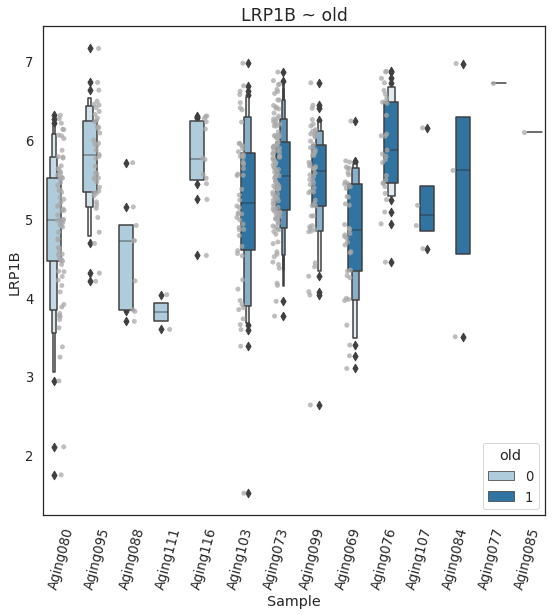

In [38]:
# max non-significat by coef (increasing)
nonsig_results = glm_results.loc[(glm_results['fdr_bh'] > 0.05) & 
                                 (~glm_results['z'].isna())]
this_results = nonsig_results.loc[nonsig_results['coef'] == max(nonsig_results['coef'])]
this_hit = this_results.sort_values(by=['coef'], ascending=True).iloc[0]
prep_plot_feature(adata, this_hit)
prep_plot_feature(adata, this_hit, filter_zeros=True)